In [40]:
%reset
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
import pickle
X = pickle.load(open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images_smaller.pkl"), "rb" ) )
titles = pd.Series(X[1])
X = X[0]

In [44]:
y = np.hstack([np.ones(len(X)//2),np.zeros(len(X)//2)]).astype(int)

In [45]:
i_range = np.arange(y.shape[0])

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X, y, i_range, test_size=0.2, random_state=420, stratify=y)

In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((480, 120, 646, 3), (120, 120, 646, 3), (480,), (120,))

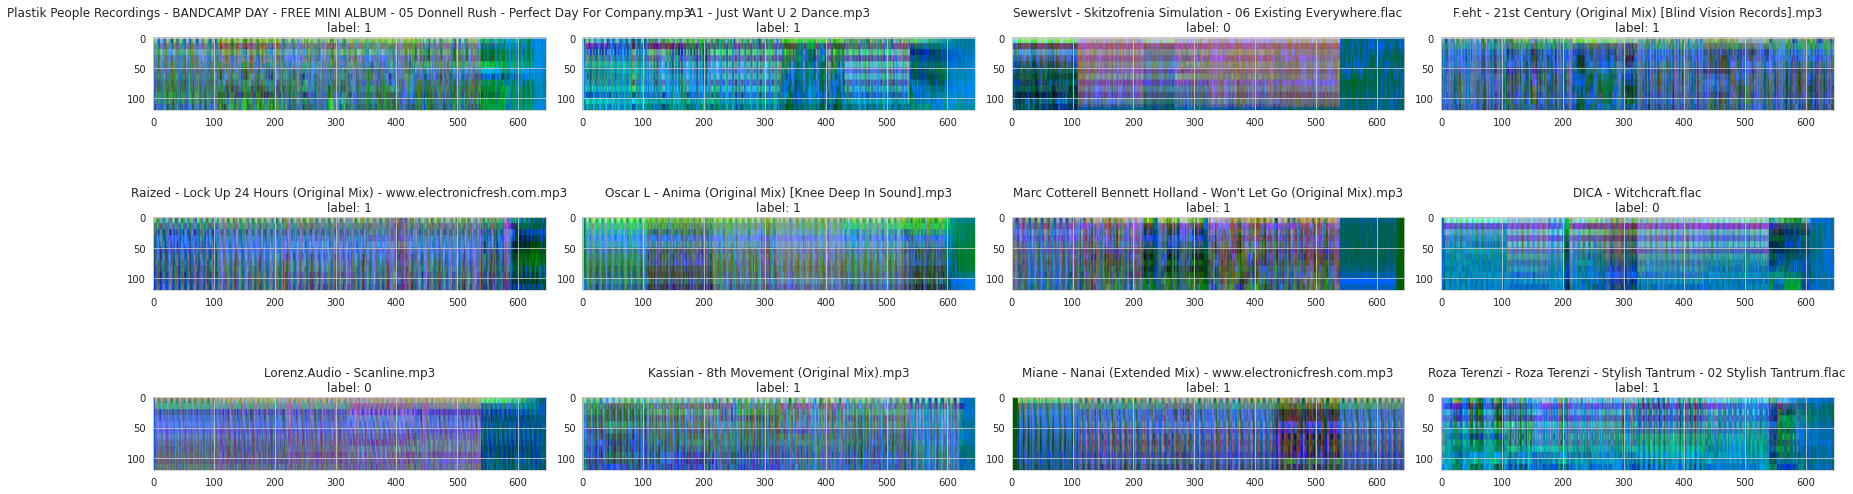

In [72]:
images = np.random.choice(range(X.shape[0]), 12, replace = False) #type: ignore
plt.figure(2, figsize=(24, 24))
for i in range(1, 13):
    plt.subplot(3, 4, i)
    plt.imshow(X[images[i-1]])
    plt.title(f"{titles[images[i-1]]}\nlabel: {y[images[i-1]]}")
plt.tight_layout()
plt.show()

In [49]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)

In [50]:
X_train.shape[1:]

(120, 646, 3)

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

def lenet5():
    model = Sequential()
    # RESIZE
    model.add(BatchNormalization(input_shape=(X_train.shape[1:])))
    model.add(MaxPooling2D(pool_size=(2, 2), input_shape=(X_train.shape[1:])))
    # CONV POOL 1
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # CONV POOL 2
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # DROPOUT AVANT FLATTEN
    model.add(Dropout(0.05))
    model.add(Flatten())
    # DENSE 1
    model.add(Dense(units=256, activation='relu'))
    # DENSE 2 DROPOUT
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.05))
    # DENSE 3
    model.add(Dense(units=128, activation='relu'))
    # Output layer
    model.add(Dense(units=1, activation = 'sigmoid'))
    return model

my_model = lenet5()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
my_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=100),
            TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]
my_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 120, 646, 3)      12        
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 60, 323, 3)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 58, 321, 16)       448       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 29, 160, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 27, 158, 32)       4640      
                                                      

In [67]:
BATCH_SIZE = 32

my_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE, 
    epochs=70, 
    callbacks=callbacks)

Epoch 1/70
8/8 [==============================] - 9s 913ms/step - loss: 1.7853 - accuracy: 0.5229 - val_loss: 4.3881 - val_accuracy: 0.5000
Epoch 2/70
8/8 [==============================] - 7s 891ms/step - loss: 0.6449 - accuracy: 0.6667 - val_loss: 0.8618 - val_accuracy: 0.5250
Epoch 3/70
8/8 [==============================] - 10s 1s/step - loss: 0.4919 - accuracy: 0.8292 - val_loss: 0.9513 - val_accuracy: 0.6083
Epoch 4/70
8/8 [==============================] - 9s 1s/step - loss: 0.3274 - accuracy: 0.8687 - val_loss: 0.7190 - val_accuracy: 0.7500
Epoch 5/70
8/8 [==============================] - 10s 1s/step - loss: 0.2428 - accuracy: 0.9042 - val_loss: 2.3504 - val_accuracy: 0.5417
Epoch 6/70
8/8 [==============================] - 9s 1s/step - loss: 0.1871 - accuracy: 0.9312 - val_loss: 3.6433 - val_accuracy: 0.5000
Epoch 7/70
8/8 [==============================] - 10s 1s/step - loss: 0.0985 - accuracy: 0.9729 - val_loss: 1.7616 - val_accuracy: 0.6083
Epoch 8/70
8/8 [================

In [68]:
from sklearn.metrics import f1_score, confusion_matrix

y_pred = my_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1,0).reshape(y_pred.shape[0])

loss, metric = my_model.evaluate(X_test, y_test, verbose=0)

print('loss is:', loss)
print('accu is:', metric)
print("f1_score is:",f1_score(y_test, y_pred))

loss is: 0.5506632328033447
accu is: 0.875
f1_score is: 0.8648648648648648


[]

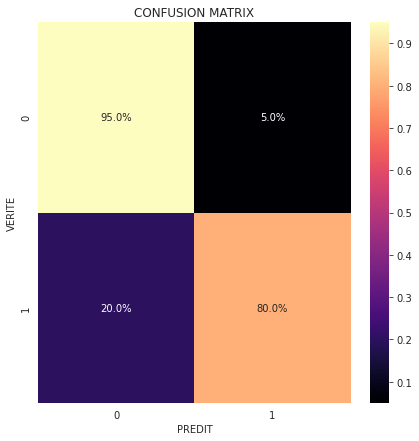

In [73]:
conf = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(7,7))
heat = sns.heatmap(conf, annot=True, cmap="magma", fmt = ".1%")
heat.set(xlabel="PREDIT", ylabel="VERITE", title="CONFUSION MATRIX")
plt.plot()

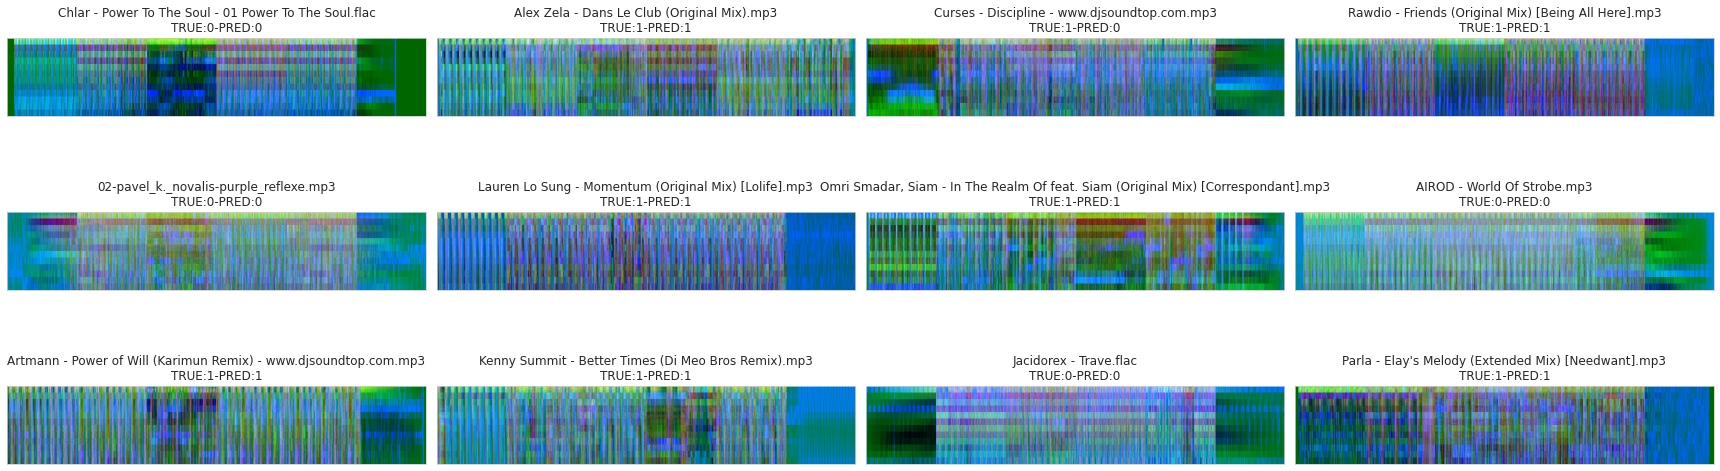

In [71]:
images = np.random.choice(range(X_test.shape[0]), 12, replace = False) #type: ignore
plt.figure(2, figsize=(24, 24))
for i in range(1, 13):
    plt.subplot(3, 4, i)
    fig = plt.imshow(X_test[images[i-1]])
    plt.title(f"{titles[i_test[images[i-1]]]}\nTRUE:{y_test[images[i-1]]}-PRED:{y_pred[images[i-1]]}")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()